In [13]:
import os
os.listdir()

['.gitkeep',
 'energy_analysis.ipynb',
 'statistic_id239782_primary-energy-consumption-in-the-us-by-sector-1975-2024.xlsx']

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [45]:
df = pd.read_excel("statistic_id239782_primary-energy-consumption-in-the-us-by-sector-1975-2024.xlsx"
, sheet_name = 'Data', skiprows = 4)
df = df.dropna(axis =1, how = "all")
df = df.rename(columns={df.columns[0]: "Year"})
df = df.rename(columns={"Electric power*": "Electric Power"})

df.head()


,Year,Electric Power,Transportation,Industrial,Residential,Commercial
0,1975,18.15,18.21,21.40,7.99,4.06
1,1980,22.31,19.66,22.53,7.44,4.11
2,1985,23.99,20.04,19.36,7.15,3.73
3,1990,28.34,22.37,21.10,6.55,3.89
4,1995,31.25,23.76,22.62,6.93,4.10


## Question 1: How has total primary energy consumption changed over the past 50 years?


In [46]:
#Total Energy Column
df["Total Energy"] = df[
    ["Electric Power", "Transportation", "Industrial", "Residential", "Commercial"]
].sum(axis=1)

df[["Year", "Total Energy"]].head()
df[["Year", "Total Energy"]].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Year          22 non-null     int64  
 1   Total Energy  22 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 484.0 bytes


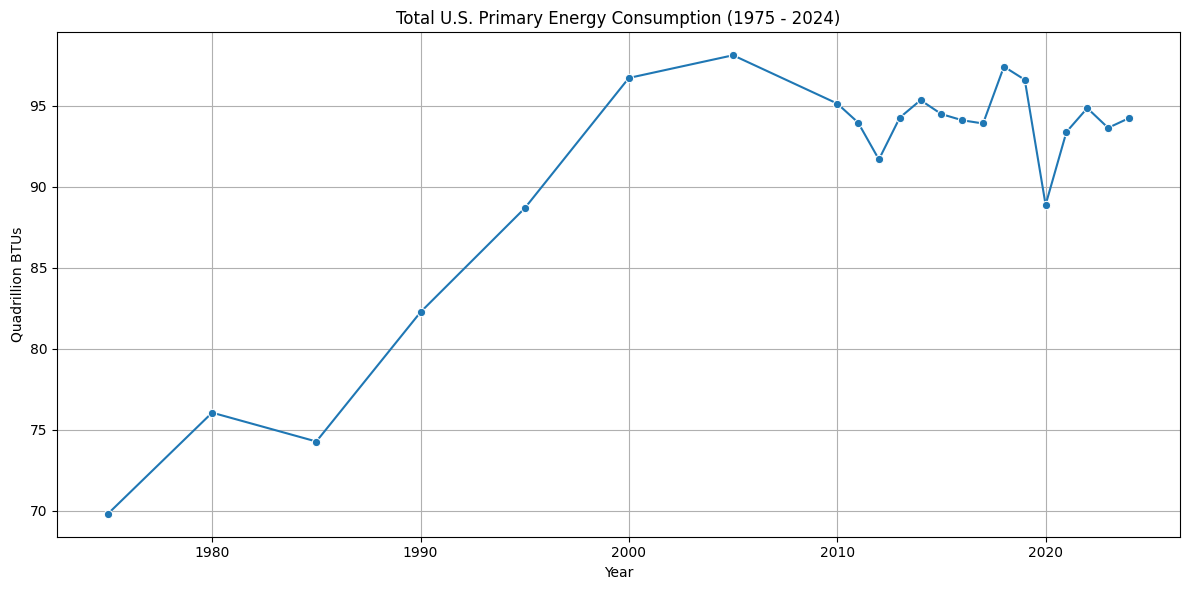

In [47]:
#Absolute Change and Percent Change
absoulute_change = df["Total Energy"].iloc[-1] - df["Total Energy"].iloc[0]
percent_change = (absoulute_change / df["Total Energy"].iloc[0]) * 100
absoulute_change, percent_change


import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (12,6))
sns.lineplot(data = df, x = "Year", y = "Total Energy", marker = "o")

plt.title("Total U.S. Primary Energy Consumption (1975 - 2024)")
plt.xlabel("Year")
plt.ylabel("Quadrillion BTUs")
plt.grid(True)
plt.tight_layout()
plt.show()

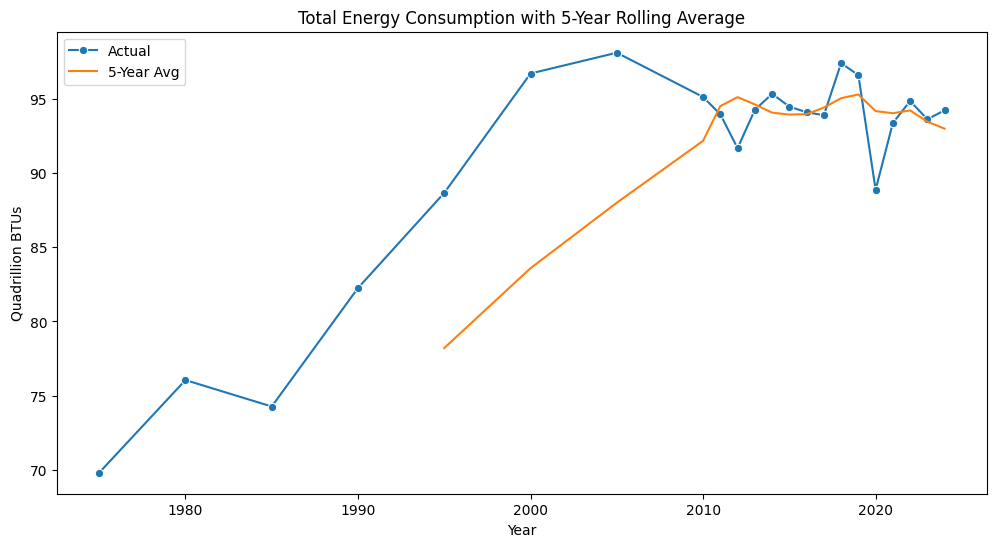

In [48]:
df["rolling_avg_5yr"] = df["Total Energy"].rolling(window=5).mean()

plt.figure(figsize=(12,6))
sns.lineplot(data=df, x="Year", y="Total Energy", label="Actual", marker="o")
sns.lineplot(data=df, x="Year", y="rolling_avg_5yr", label="5-Year Avg")

plt.title("Total Energy Consumption with 5-Year Rolling Average")
plt.xlabel("Year")
plt.ylabel("Quadrillion BTUs")
plt.legend()
plt.show()


## Question 2; Which sector's energy use has the fastest growth rate?

In [ ]:
#Grouping the sectors
sectors = ["Electric Power", "Transportation", "Industrial", "Residential", "Commercial"]

#Calculating Growth Rate (Final-Initial)/Initial * 100

growth_rates = {}

for sector in sectors:
    start = df[sector].iloc[0]
    end = df[sector].iloc[-1]

    growth_rate = ((end - start) / start) * 100
    growth_rates[sector] = growth_rate
growth_rates

#Making this easy to read

growth_df = pd.DataFrame.from_dict(
    growth_rates,
    orient = "index",
    columns = ["percent_growth"]
). sort_values(by = "percent_growth", ascending = False)

print(growth_df)

#Finding fastest growing sector

fastest_sector = growth_df.idxmax()[0]
fastest_growth = growth_df["percent_growth"].max()

fastest_sector, fastest_growth


                percent_growth
Electric Power       80.606061
Transportation       54.255903
Commercial           13.054187
Industrial            5.747664
Residential         -23.279099


C:\Users\danie\AppData\Local\Temp\ipykernel_28988\848163741.py:28: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  fastest_sector = growth_df.idxmax()[0]


('Electric Power', np.float64(80.60606060606062))

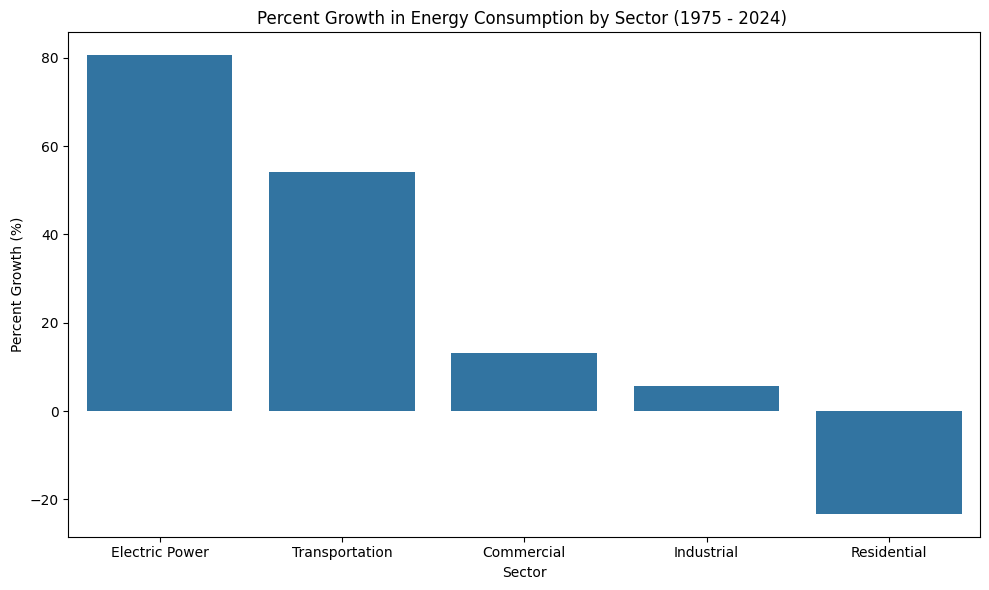

In [ ]:
# Let do a barplot for comparison
import seaborn as sns 
import matplotlib.pyplot as plt

plt.figure(figsize = (10, 6))
sns.barplot(
    data = growth_df.reset_index(),
    x = "index",
    y = "percent_growth"
)

plt.title("Percent Growth in Energy Consumption by Sector (1975 - 2024)")
plt.xlabel("Sector")
plt.ylabel("Percent Growth (%)")
plt.xticks(rotation = 0)
plt.tight_layout()
plt.show()



In [63]:
growth_df
fastest_sector, fastest_growth

('Electric Power', np.float64(80.60606060606062))

## Question 3: Can U.S. electric power energy consumption be predicted using historical energy consumption in other sectors?

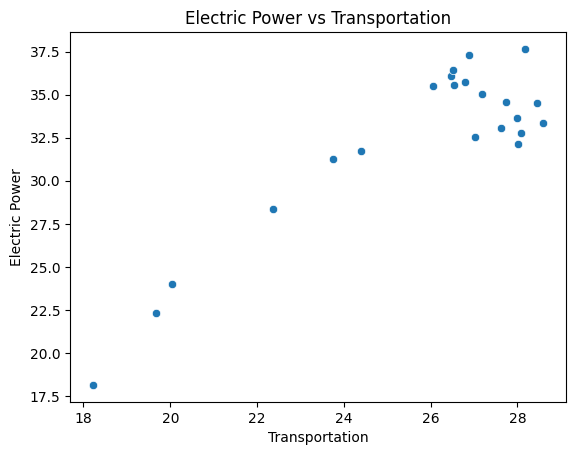

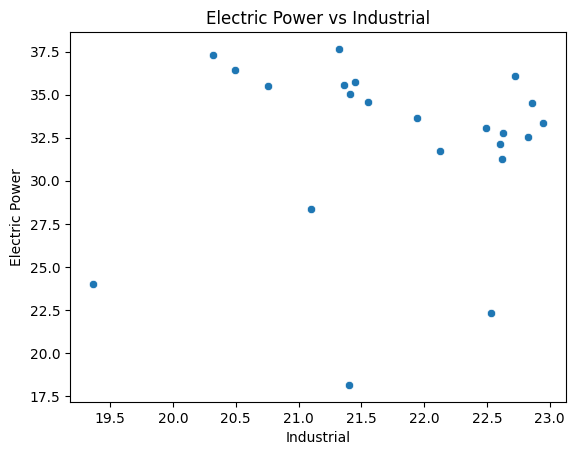

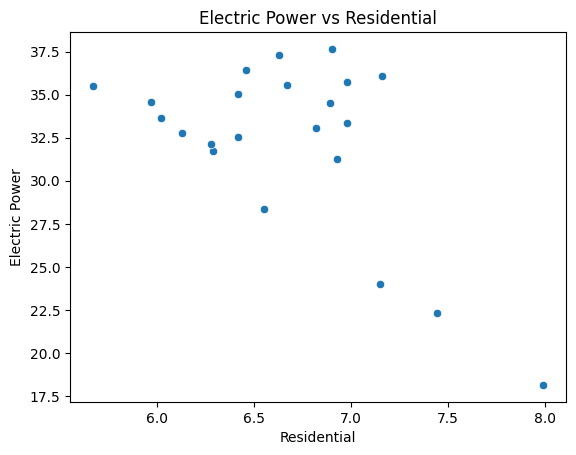

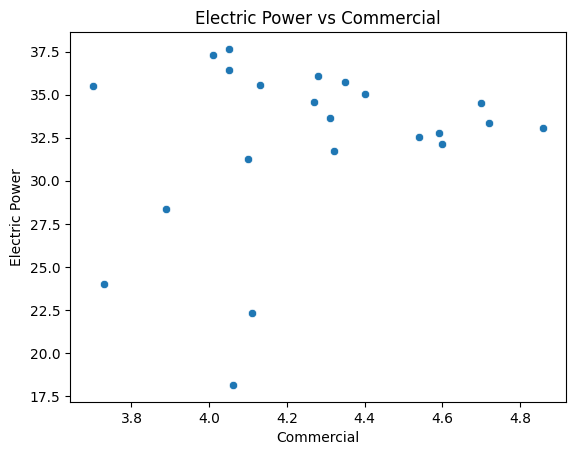

,Electric Power,Transportation,Industrial,Residential,Commercial
Electric Power,1.000000,0.891183,0.056227,-0.585581,0.236443
Transportation,0.891183,1.000000,0.325508,-0.594635,0.576099
Industrial,0.056227,0.325508,1.000000,0.046177,0.773778
Residential,-0.585581,-0.594635,0.046177,1.000000,-0.050326
Commercial,0.236443,0.576099,0.773778,-0.050326,1.000000


In [ ]:
# Let's figure out if there is a linear relationship or not. 

sns.scatterplot(x = df["Transportation"], y = df["Electric Power"])
plt.title("Electric Power vs Transportation")
plt.show()

sns.scatterplot(x = df["Industrial"], y = df["Electric Power"])
plt.title("Electric Power vs Industrial")
plt.show()

sns.scatterplot(x = df["Residential"], y = df["Electric Power"])
plt.title("Electric Power vs Residential")
plt.show()

sns.scatterplot(x = df["Commercial"], y = df["Electric Power"])
plt.title("Electric Power vs Commercial")
plt.show()

# Transportation and Residential seems to be the only ones that show slight linearity.
# But let's check using Correlation Test

df[["Electric Power", "Transportation", "Industrial", "Residential", "Commercial"]].corr()

#Transporation has the strongest linear relationship with Electric Power the other correlations aren' strong
#We could do linear regression with just transportation. 

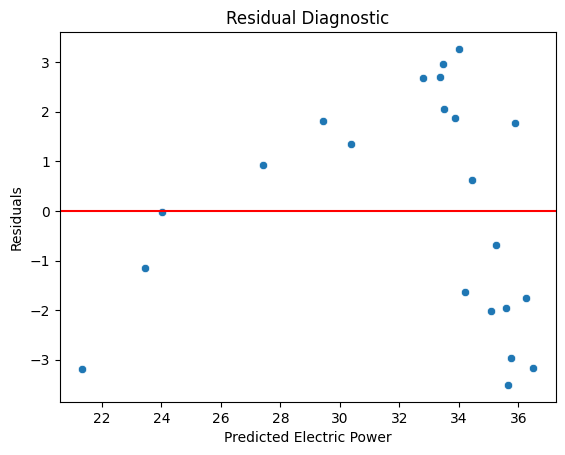

In [78]:
#Linear Regression + checking to see if i'll truly have a valid model

from sklearn.linear_model import LinearRegression
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

x = df[["Transportation"]]
y = df["Electric Power"]

model = LinearRegression()
model.fit(x, y)

slope = model.coef_[0]
intercept = model.intercept_

#Generating predictions
df["predicted_Electric_Power"] = model.predict(x)
df[["Year", "Electric Power", "predicted_Electric_Power"]].head()

#Getting r^2
r2 = model.score(x,y)
r2 #Value is 0.794 which is good!

#Now will the plot be linear or nonlinear
residual  = y - df["predicted_Electric_Power"]

sns.scatterplot(x = df["predicted_Electric_Power"], y = residual)
plt.axhline(0, color = "red")
plt.xlabel("Predicted Electric Power")
plt.ylabel("Residuals")
plt.title("Residual Diagnostic")
plt.show()

#Random pattern so linear regression is valid

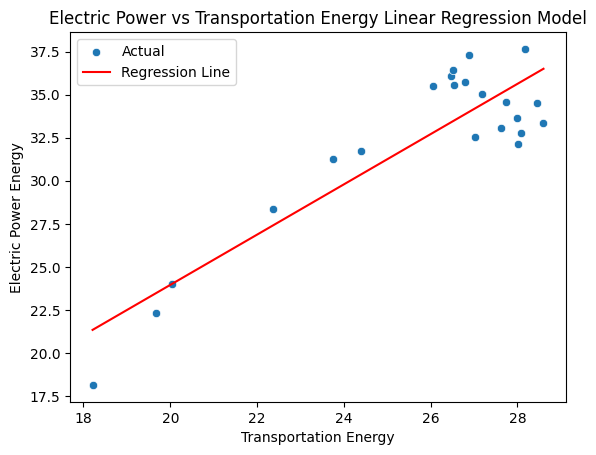

In [77]:
#Graph to show how linear regression accuracy

sns.scatterplot(x = df["Transportation"], y = df["Electric Power"], label = "Actual")
sns.lineplot(x = df["Transportation"], y = df["predicted_Electric_Power"], color = "red", label = "Regression Line")
plt.xlabel("Transportation Energy")
plt.ylabel("Electric Power Energy")
plt.legend()
plt.title ("Electric Power vs Transportation Energy Linear Regression Model")
plt.show()